# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: 201466349, 313591851

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01, title=''):
    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
    plt.title(f'{title}')
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    plt.show()

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

In [4]:
np.unique(y_training)

array([0, 1])

In [5]:
def plot_x_0_histogram(n_first_samples=None, bins=40):
    feature_0 = X_training[:n_first_samples, 0]
    feature_0_cls_0 = feature_0[y_training[:n_first_samples] == 0]
    feature_0_cls_1 = feature_0[y_training[:n_first_samples] == 1]
    plt.hist(feature_0_cls_0, label='0', bins=bins, alpha=0.5)
    plt.hist(feature_0_cls_1, label='1', bins=bins, alpha=0.5)
    plt.title(
        f'{f"{n_first_samples} first" if n_first_samples else "All"} samples $x_0$ histogram split by label values')
    plt.legend(title='label')
    plt.show()

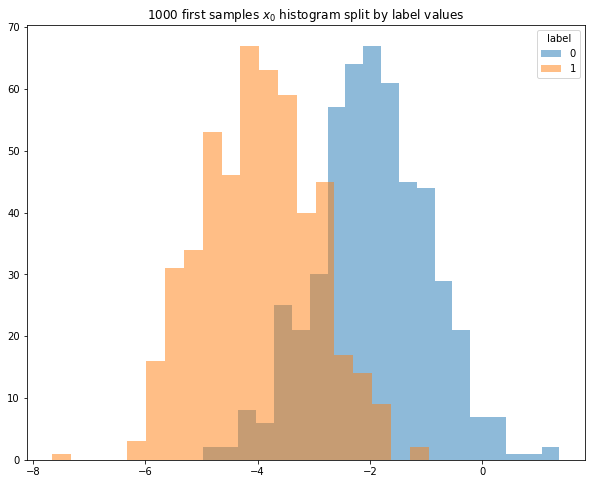

In [6]:
plot_x_0_histogram(n_first_samples=1000, bins=20)

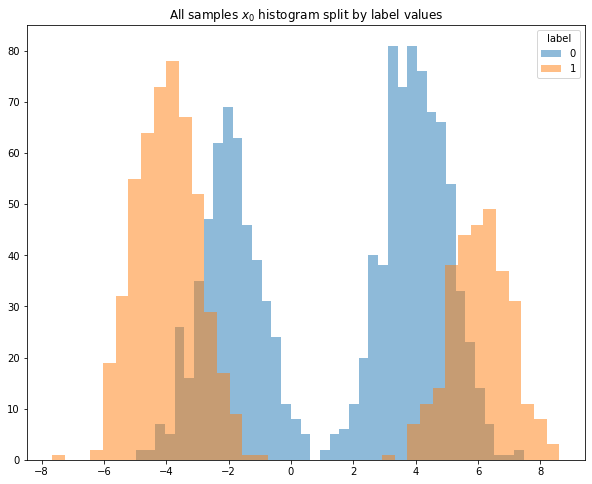

In [7]:
plot_x_0_histogram()

In [8]:
def plot_features_scatter(n_first_samples=None):
    scatter = plt.scatter(x=X_training[:n_first_samples, 0], y=X_training[:n_first_samples, 1],
                          c=y_training[:n_first_samples], cmap=ListedColormap(['r', 'b']))
    plt.title(
        f'{"All" if not n_first_samples else f"{n_first_samples} first"} samples $x_0, x_1$ scatter colored by label values')
    plt.legend(title='label', handles=scatter.legend_elements()[0], labels=('0', '1'))
    plt.show()

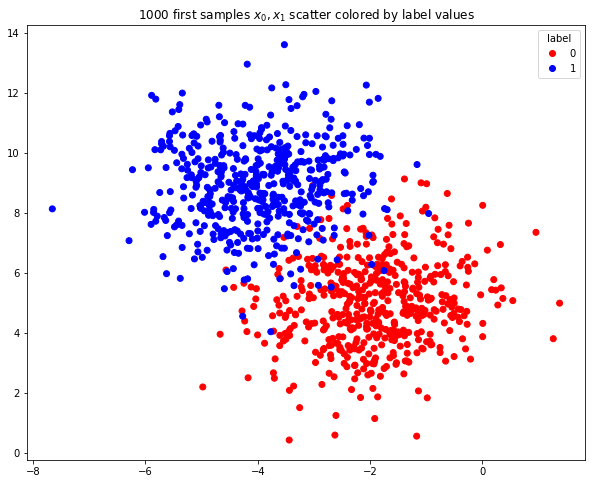

In [9]:
plot_features_scatter(1000)

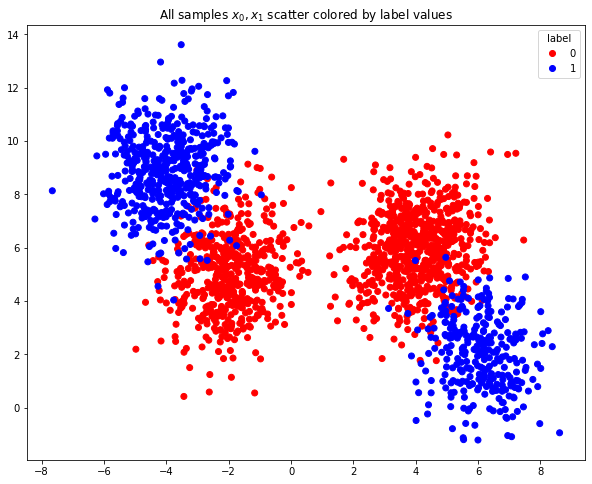

In [10]:
plot_features_scatter()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector.

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [11]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """

    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = None
        self.J_history = None

    @staticmethod
    def _h(theta, X):
        """
        calculate sigmoid of theta and X
        :param theta: shape(n_features,) where n == number of features
        :param X: shape(n_samples,n_features)
        :return: sigmoid calculation shape(n_samples,)
        """
        return 1 / (1 + np.exp(- X @ theta))

    @staticmethod
    def _compute_cost(X, y, theta):
        """
        Computes cost function for logistic regression.

        Input:
        - X: inputs
        - y: true labels
        - theta: the parameters (weights) of the model being learned.

        Returns a single value:
        - J: the cost associated with the current set of parameters (single number).
        """
        m = len(y)
        predictions = LogisticRegressionGD._h(theta=theta, X=X)
        return - (1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

    @staticmethod
    def _add_bias(X):
        """
        Add a bias column of 1s to the dataset X
        :param X: samples
        :return: X with an added 1s column
        """
        return np.hstack([np.ones([X.shape[0], 1]), X])

    def fit(self, X, y):
        """
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        np.random.seed(self.random_state)

        X = self._add_bias(X)
        m, n = X.shape
        self.theta = np.random.rand(n)
        self.J_history = []

        for i in range(self.n_iter):
            prediction = LogisticRegressionGD._h(self.theta, X)
            gradient = (1 / m) * (X.T @ (prediction - y))
            self.theta = self.theta - self.eta * gradient
            self.J_history.append(self._compute_cost(X, y, self.theta))

            if len(self.J_history) > 1 and np.abs(self.J_history[-2] - self.J_history[-1]) < self.eps:
                break

    def predict(self, X):
        X = self._add_bias(X)
        p = self._h(self.theta, X)
        return np.rint(p).astype(int)

    def score(self, X, y):
        """
        Accuracy score of a fitted model on a given test set
        :param X: samples shape(n_samples,n_features)
        :param y: true labels shape(n_samples,)
        :return: accuracy score (n_correct_predictions / n_predictions)
        """
        return np.count_nonzero(self.predict(X) == y) / len(y)


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [12]:
def k_fold_cross_validation_score(X, y, estimator, k=5):
    shuffled = np.column_stack((X.copy(), y.copy()))
    np.random.shuffle(shuffled)
    folds = np.vsplit(shuffled, k)
    scores = []
    for i in range(k):
        validation_fold = folds[i]
        train_folds = folds.copy()
        train_folds.pop(i)
        train_data = np.vstack(train_folds)
        estimator.fit(train_data[:, :-1], train_data[:, -1])
        scores.append(estimator.score(validation_fold[:, :-1], validation_fold[:, -1]))

    return scores

In [13]:
#### Your code here ####
def search_best_hyperparams(X_training, y_training):
    etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
    epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
    scores_mean = []
    for eta in etas:
        for eps in epss:
            mean_score = np.mean(
                k_fold_cross_validation_score(X_training, y_training, LogisticRegressionGD(eta=eta, eps=eps)))
            scores_mean.append((eta, eps, mean_score))

    return scores_mean

In [14]:
scores_mean = np.vstack(search_best_hyperparams(X_training, y_training))
lr_best_params = scores_mean[np.argmax(scores_mean[:, 2])]

In [15]:
lr = LogisticRegressionGD(eta=lr_best_params[0], eps=lr_best_params[1])
lr.fit(X_training, y_training)
lr.score(X_test, y_test)

0.792

In [16]:
print(f'best eta={lr_best_params[0]}\nbest eps={lr_best_params[1]}')

best eta=0.05
best eps=1e-06


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [17]:
def normal_pdf(x, mean, std):
    """
    Calculate normal desnity function for a given x, mean and standrad deviation.

    Input:
    - x: A value we want to compute the distribution for.
    - mean: The mean value of the distribution.
    - std:  The standard deviation of the distribution.

    Returns the normal distribution pdf according to the given mean and std for the given x.
    """
    return (1 / np.sqrt(2 * np.pi * std)) * np.exp(-(((x - mean) ** 2) / (2 * (std ** 2))))

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [18]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

        self.vW = None
        self.mMu = None
        self.mS = None
        self.mR = None

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        np.random.seed(self.random_state)
        N, d = data.shape
        self.vW = np.ones(self.k) / self.k
        self.mMu = data[np.random.choice(N, size=self.k)]
        self.mS = np.ones(self.k) * np.std(data)
        self.mR = np.zeros((N, self.k))

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        normalizer = np.sum([self.vW[j] * normal_pdf(data, self.mMu[j], self.mS[j]) for j in range(self.k)], axis=0)
        for k in range(self.k):
            self.mR[:, k] = np.column_stack((self.vW[k] * normal_pdf(data, self.mMu[k], self.mS[k])) / normalizer)

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        N, d = data.shape
        for j in range(self.k):
            self.vW[j] = np.sum(self.mR[:, j], axis=0) / N
            self.mMu[j] = (self.mR[:, j] @ data) / (self.vW[j] * N)
            self.mS[j] = np.sqrt((self.mR[:, j] @ (data - self.mMu[j])**2) / (self.vW[j] * N))

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        cost_history = []
        for i in range(self.n_iter):
            self.expectation(data)
            self.maximization(data)

            cost_history.append(self._calc_cost(data))
            if len(cost_history) > 1 and np.abs(cost_history[-2] - cost_history[-1] < self.eps):
                break

    def get_dist_params(self):
        return self.mMu, self.mS, self.vW

    def _calc_cost(self, data):
        cost = 0
        for j in range(self.k):
            cost += np.sum(-np.log(self.vW[j] * normal_pdf(data, self.mMu[j], self.mS[j])))
        return cost


## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [19]:
class NaiveGMMClassDistribution:
    def __init__(self, X, y, k, label, random_state=1):
        # calc prior
        N, d = X.shape
        self.__prior = (np.bincount(y.astype(int)) / N)[label]

        # calc dist params
        class_instances = X[np.where(y == label)[0], :]
        self.pdfs = []
        for col in range(d):
            em = EM(k=k, random_state=random_state)
            em.fit(np.row_stack(class_instances[:, col]))
            self.pdfs.append(em.get_dist_params())

    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        return self.__prior

    def get_instance_likelihood(self, x):
        """
        Returns the likelihhod porbability of the instance under the class according to the dataset distribution.
        """
        x = x if len(x.shape) > 1 else np.column_stack(x)
        N, d = x.shape
        p = np.zeros(shape=(N, d))
        for col in range(d):
            means, stds, ws = self.pdfs[col]
            p[:, col] = np.sum([ws[k] * normal_pdf(x[:, col], means[k], stds[k]) for k  in range(len(means))], axis=0)
        return np.prod(p, axis=1 if N > 1 else None)

    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        return self.get_prior() * self.get_instance_likelihood(x)

In [20]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1, random_state=1):
        self.k = k
        self.random_state = random_state

        self._prior = None
        self.gmms = None

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.gmms = []
        for label in np.unique(y):
            self.gmms.append(NaiveGMMClassDistribution(X, y, k=self.k, label=label, random_state=self.random_state))


    def predict(self, X):
        """Return the predicted class label"""
        axis = 0 if len(X.shape) > 1 else None
        return np.argmax([gmm.get_instance_posterior(X) for gmm in self.gmms], axis=axis)

    def score(self, X, y):
        """
        Accuracy score of a fitted model on a given test set
        :param X: samples shape(n_samples,n_features)
        :param y: true labels shape(n_samples,)
        :return: accuracy score (n_correct_predictions / n_predictions)
        """
        return np.count_nonzero(self.predict(X) == y) / len(y)


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [21]:
#### Your code here ####
RANDOM_STATE = 42
lr = LogisticRegressionGD(eta=lr_best_params[0], eps=lr_best_params[1], random_state=RANDOM_STATE)
nb = NaiveBayesGaussian(k=2, random_state=RANDOM_STATE)

In [22]:
X_training_1000 = X_training[:1000]
y_training_1000 = y_training[:1000]

X_test_500 = X_test[:500]
y_test_500 = y_test[:500]

In [23]:
def fit_analyze_models(X_train,y_train, X_test, y_test):
    for model, name in [(lr, 'Logistic Regression'), (nb, 'Gaussian Naive Bayes')]:
        model.fit(X_train, y_train)
        print(f'{name} train accuracy score: {model.score(X_train, y_train)}')
        print(f'{name} test accuracy score: {model.score(X_test, y_test)}')
        plot_decision_regions(X_train, y_train, model, title=f'{name} decision boundary plot')
        if name == 'Logistic Regression':
            plt.plot(model.J_history)
            plt.xlabel('iteration #')
            plt.ylabel('cost')
            plt.title('Logistic regression training cost values over iterations')
            plt.show()

Logistic Regression train accuracy score: 0.965
Logistic Regression test accuracy score: 0.938


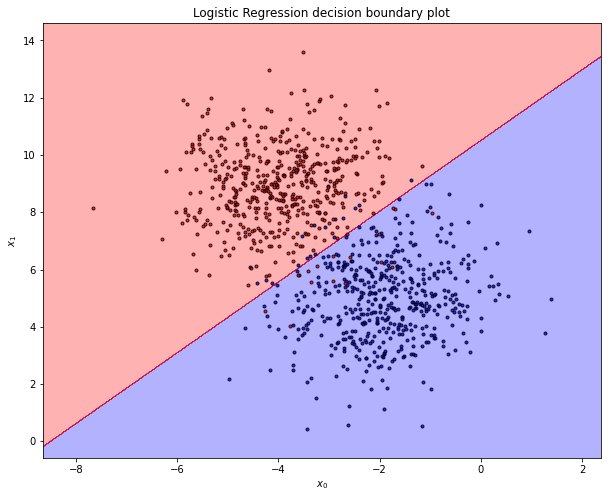

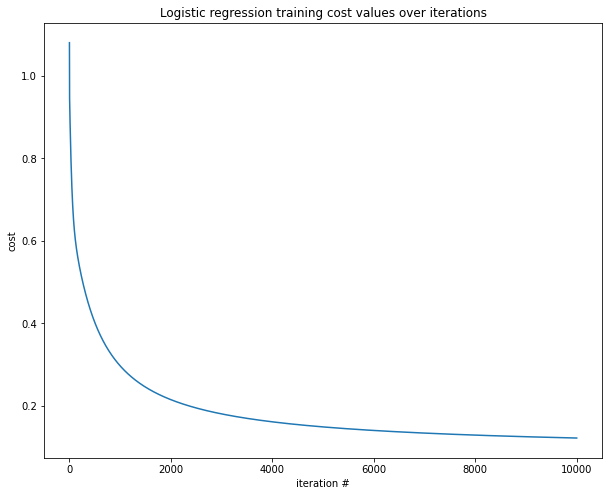

Gaussian Naive Bayes train accuracy score: 0.966
Gaussian Naive Bayes test accuracy score: 0.942


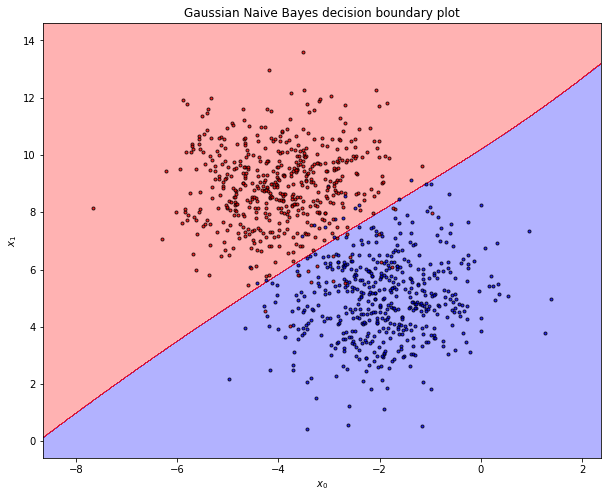

In [24]:
fit_analyze_models(X_training_1000, y_training_1000, X_test_500, y_test_500)

#### Logistic Regression
The first 1000 samples in the train set are very easily linear separable, which leads to a very good Logistic Regression classifier. We can see that the cost reduction is close to exponential during the iterations.

#### Naive Gaussian
We've seen in the beginning of the assignment that the data is also separable using the distribution of the features, since $x_0, x_1$ behave like GMMs that defer in their class value (the features distributions split the data to its classes). Meaning, we can infer the label by calculating the posterior probability.

Logistic Regression train accuracy score: 0.796
Logistic Regression test accuracy score: 0.792


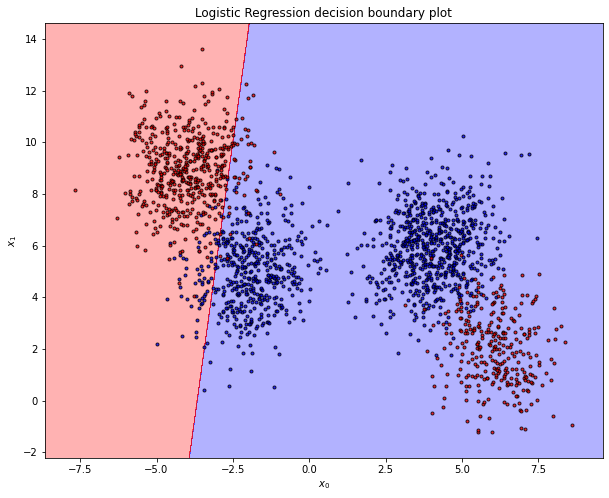

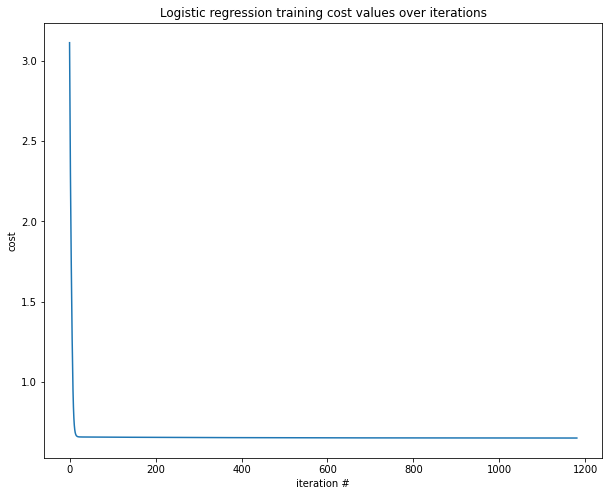

Gaussian Naive Bayes train accuracy score: 0.8345
Gaussian Naive Bayes test accuracy score: 0.817


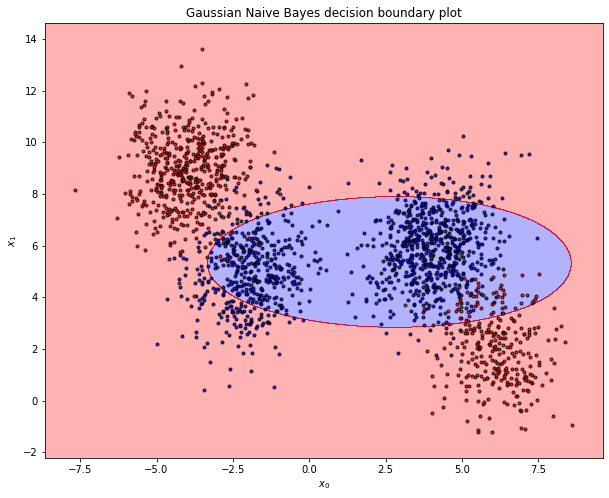

In [25]:
fit_analyze_models(X_training, y_training, X_test, y_test)

#### Logistic Regression
The entire dataset is not linear separable in an intuitive way, and this leads to a worse estimator. We can see that the cost reduction was very quick in the beginning of the training process, but then it managed to improve in small amounts only.

#### Naive Gaussian
When looking at the full dataset, we saw that it is comprised of GMMs in both of the features, but there is some dependency between the 2 features given some label y. This causes the assumption of the Naive Bayes algorythm to be wrong, leading to less accurate classification, although a better than the linear one.

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

### 1. Bayes Gaussian > Logistic regression

In [26]:
def plot_pairplots(X, y):
    df = pd.DataFrame(X, columns=['x0', 'x1', 'x2'])
    df['y'] = y
    pp = sns.pairplot(df, hue='y')
    pp.fig.suptitle('pairplots of X features', y=1.08)

In [27]:
def plot_3D(X, y):
    ax = plt.axes(projection='3d')
    scatter = ax.scatter3D(X[:,0],X[:, 1], X[:, 2], c=y, cmap=ListedColormap(['r', 'b']))
    ax.set(title='3D representation of X')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    ax.legend(*scatter.legend_elements(), title='label')

In [28]:
def fit_print_scores(X, y, k=2, random_state=1):
    for model, name in [
        (LogisticRegressionGD(random_state=random_state), 'Logistic Regression'),
        (NaiveBayesGaussian(k=k, random_state=RANDOM_STATE), 'Gaussian Naive Bayes')
    ]:
        model.fit(X, y)
        print(f'{name} accuracy score: {model.score(X, y)}')

We created a non-linear-separable dataset by creating the 3 features using a GMM of 2 multivariate Gaussian's with 0 covarience among the features. By mixing the classes between the 2 Gaussians,
the data to have no "natural" decision plane as seen in the 3d image, but since 75% of the samples' labels correlate to the GMM they derive from (150 samples from GMM1 are "1" and 150 samples from GMM2 are "0")
We can get a good classification of those points, resulting in a ~0.75 accuracy

In [29]:
N1 = 200
N2 = 200

vMu1 = np.array([1, 2, 3])
vMu2 = np.array([0, 1.5, -3])

mSig1 = np.eye(3)
mSig2 = np.eye(3)

X1 = multivariate_normal.rvs(mean=vMu1, cov=mSig1, size=N1, random_state=RANDOM_STATE)
X2 = multivariate_normal.rvs(mean=vMu2, cov=mSig2, size=N2, random_state=RANDOM_STATE)

X = np.r_[X1, X2]
y = np.concatenate((np.ones(50), np.zeros(N1+N2-100), np.ones(50))).astype(int)

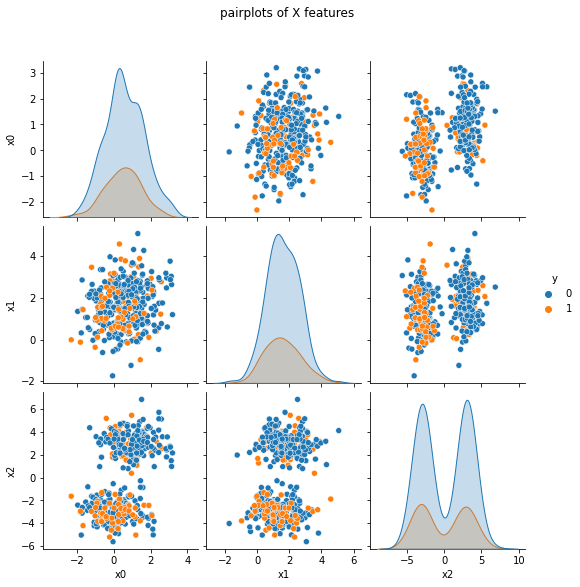

In [30]:
plot_pairplots(X,y)

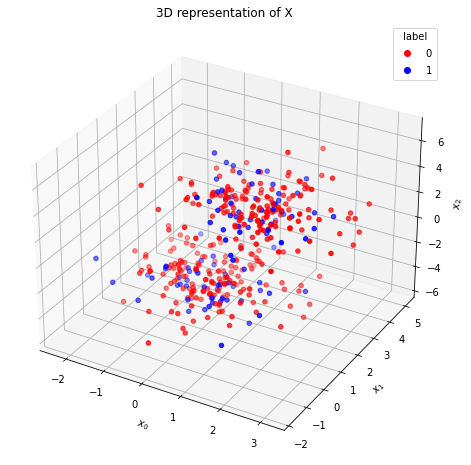

In [31]:
plot_3D(X, y)

In [32]:
fit_print_scores(X, y, random_state=RANDOM_STATE)

Logistic Regression accuracy score: 0.3775
Gaussian Naive Bayes accuracy score: 0.75


### 2.  Logistic regression > Bayes Gaussian

We created a dataset by generating the 3 features using a GMM of 2 multivariate Gaussian's with a significant covariance among the features.
The 2 GMMs have similar means, stds and covariance magnitude values, and differ in the direction of the connection between the features.

Next, we used a linear combination of the 3 features to assign a class per instance of data.

As expected, the Logistic Regression classifier, as a linear based model, performs well and produces a very high accuracy score.
On the other hand, the Naive Bayes Gaussian, has a lesser score, since the assumption of conditional feature independence given y is wrong.
This causes some mistakes in the classification of the data therefore a lesser accuracy score.

In [33]:
N1 = 100
N2 = 100

vMu1 = np.array([0, 0, 0])

mSig1 = np.array([[1, 10, 100],
                  [10, 25, 10],
                  [100, 10, 50]])

mSig2 = np.array([[1, -10., -100],
                  [-10, 25, -10],
                  [-100, -10, 50]])

X1 = multivariate_normal.rvs(mean=vMu1, cov=mSig1, size=N1, random_state=RANDOM_STATE)
X2 = multivariate_normal.rvs(mean=vMu1, cov=mSig2, size=N2, random_state=RANDOM_STATE)

X = np.r_[X1, X2]
y = np.zeros(N1+N2).astype(int)
w = np.array([1, -1, 1])
y[X @ w < 0] = 1

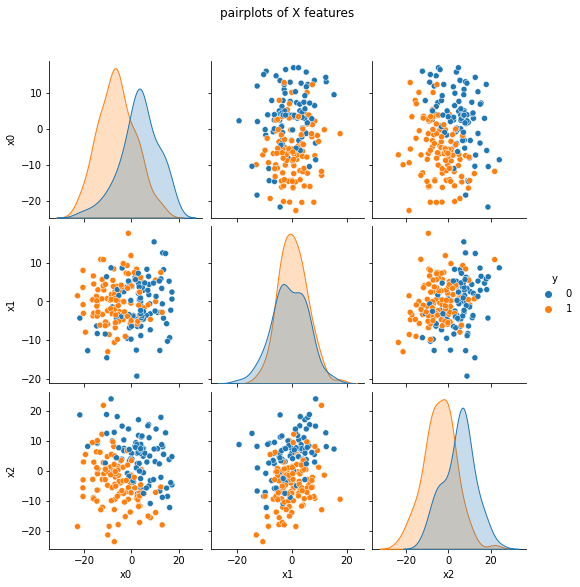

In [34]:
plot_pairplots(X, y)

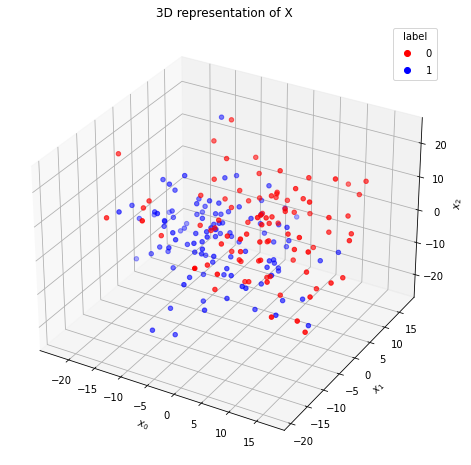

In [35]:
plot_3D(X, y)

In [36]:
fit_print_scores(X, y, random_state=RANDOM_STATE)

Logistic Regression accuracy score: 0.935
Gaussian Naive Bayes accuracy score: 0.895
